/home/backo/Documents/datathon-2025/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 1. Data Loading and Preparation ---
Dataset shape: (35899, 17)
Features used: ['product_A_sold_in_the_past', 'product_B_sold_in_the_past', 'product_A_recommended', 'product_A', 'product_C', 'product_D', 'cust_hitrate', 'cust_interactions', 'cust_contracts', 'opp_month', 'opp_old', 'competitor_Z', 'competitor_X', 'competitor_Y', 'cust_in_iberia']
--------------------------------------------------
--- 2. Model Training and Evaluation ---


/home/backo/Documents/datathon-2025/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:36:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Performance (F1 Score): 0.8175
✨ F1 Score meets the minimum performance requirement (0.7)[cite: 43].
--------------------------------------------------
--- 3. Apply Explainability Techniques (SHAP) ---

[3.1. GLOBAL INSIGHTS: Overall Feature Importance]
Showing SHAP Summary Plot...


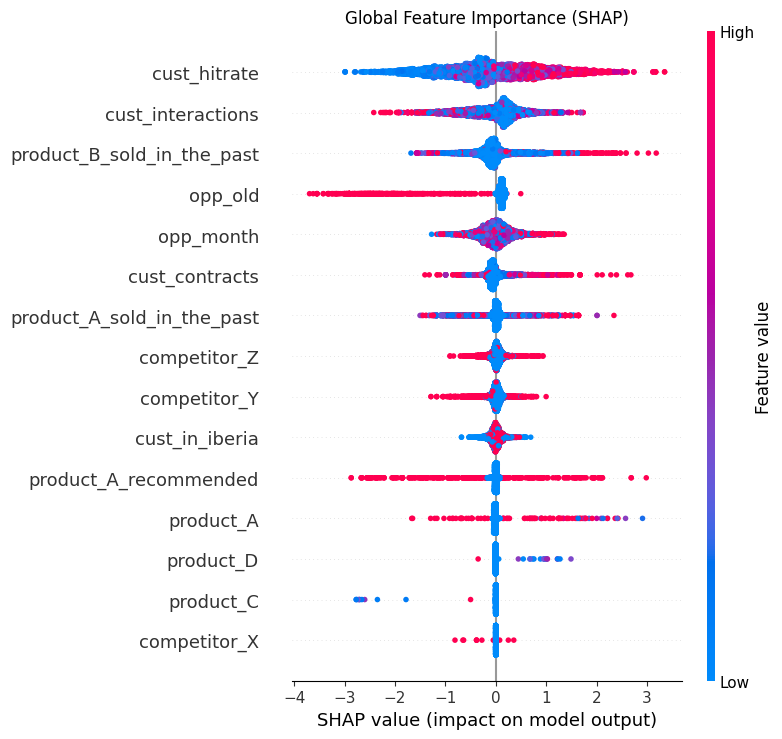

The plot above identifies the most impactful features for the prediction.
--------------------------------------------------

[3.2. DETAILED INSIGHTS: Dependence Plot for cust_contracts]
Showing SHAP Dependence Plot...


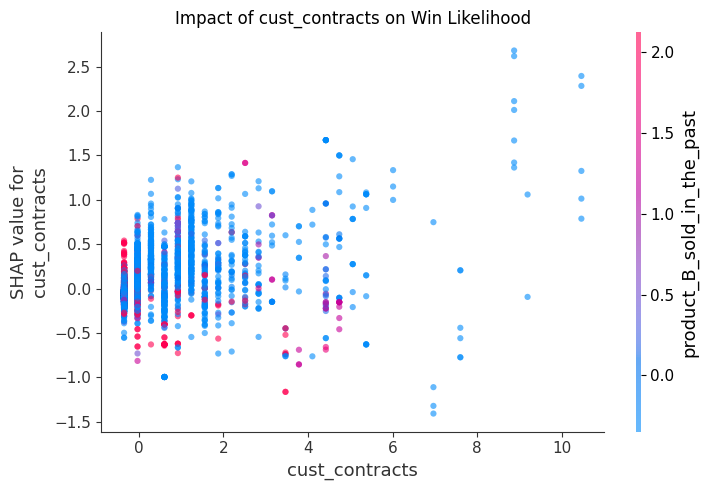

The plot above shows how the value of 'cust_contracts' directly influences the predicted outcome.
--------------------------------------------------

[3.3. LOCAL INSIGHTS: Individual Case Explanation]

Local Case 1: Predicted 'Opportunity WON' Explanation:


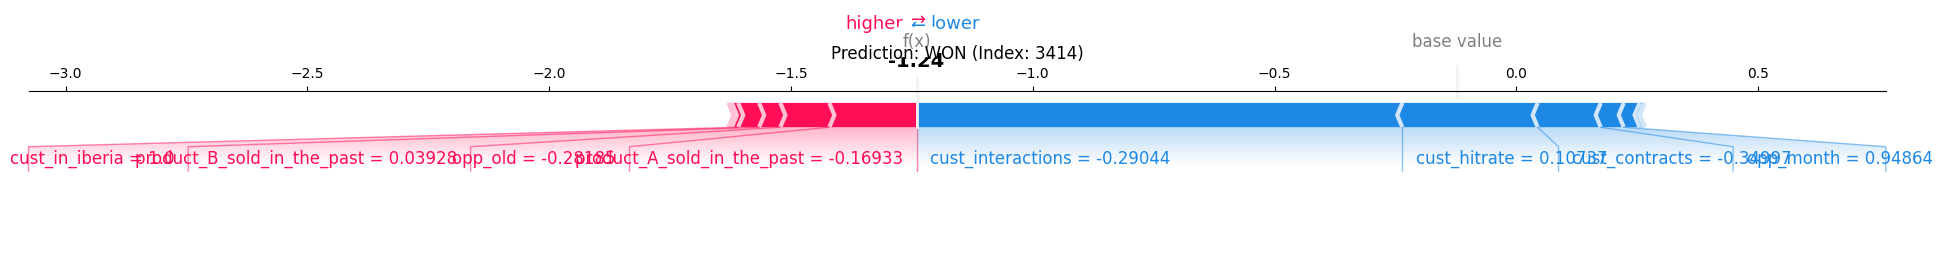


Local Case 2: Predicted 'Opportunity LOST' Explanation:


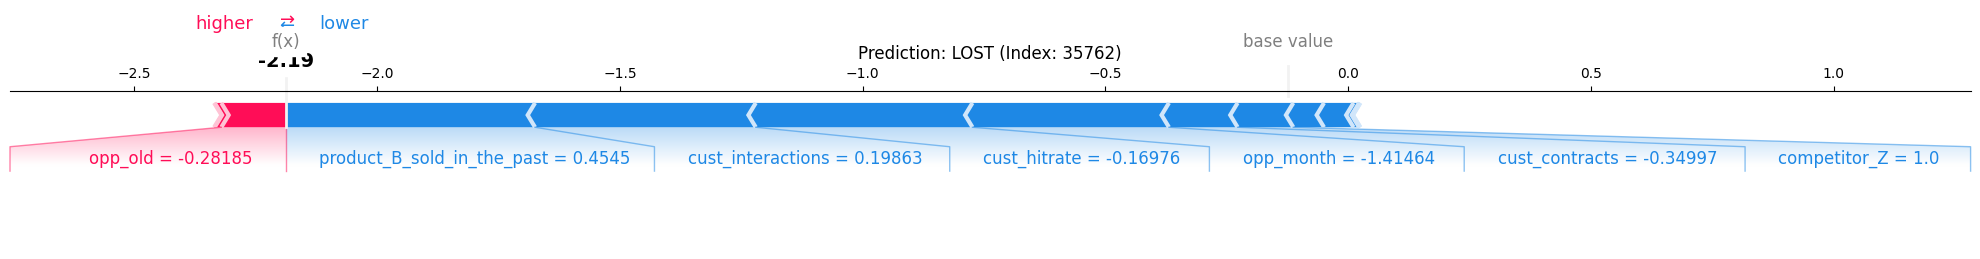

--------------------------------------------------

✅ Implementation complete. Review the generated plots for insights.


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import shap
import matplotlib.pyplot as plt

# Suppress the default SHAP explanation output to keep the console clean
# and allow only the custom print statements and plots.
shap.initjs()

# ==============================================================================
# 1. Data Loading and Preparation
# ==============================================================================

print("--- 1. Data Loading and Preparation ---")

# ⚠️ IMPORTANT: Replace this placeholder section with your actual data loading.
# The code below creates a synthetic DataFrame using the column names from the
# [cite_start]Data Dictionary [cite: 73] so the rest of the script is runnable.

# Attempt to load the actual file (if present in the environment)
df = pd.read_csv('data/dataset.csv')


# Define Features (X) and Target (y)
# [cite_start]'id' is explicitly excluded as a non-predictive feature [cite: 29]
X = df.drop(columns=['id', 'target_variable'], errors='ignore')
y = df['target_variable']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset shape: {df.shape}")
print(f"Features used: {list(X.columns)}")
print("-" * 50)


# ==============================================================================
# 2. Model Training and Evaluation (15% Focus)
# ==============================================================================

print("--- 2. Model Training and Evaluation ---")

# Initialize the XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=400, # Slightly more estimators for better performance
    max_depth=9,
    learning_rate=0.1,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"Model Performance (F1 Score): {f1:.4f}")

if f1 >= 0.7:
    print("✨ F1 Score meets the minimum performance requirement (0.7)[cite: 43].")
else:
    print("⚠️ F1 Score is below 0.7. Consider hyperparameter tuning.")
print("-" * 50)


# ==============================================================================
# 3. Apply Explainability Techniques (85% Focus)
# ==============================================================================

print("--- 3. Apply Explainability Techniques (SHAP) ---")

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(model)
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)


# [cite_start]--- 3.1. Global Insights: Which features matter most overall? [cite: 52] ---
print("\n[3.1. GLOBAL INSIGHTS: Overall Feature Importance]")
print("Showing SHAP Summary Plot...")

# SHAP Summary Plot: Features ranked by mean absolute SHAP value.
# Color indicates the feature value (red=high, blue=low).
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

print("The plot above identifies the most impactful features for the prediction.")
print("-" * 50)


# --- 3.2. Detailed Insight: Feature Dependency (Optional but helpful) ---
# Pick the most important feature (e.g., 'cust_contracts') for deeper analysis.
if 'cust_contracts' in X.columns:
    top_feature = 'cust_contracts'
    print(f"\n[3.2. DETAILED INSIGHTS: Dependence Plot for {top_feature}]")
    print("Showing SHAP Dependence Plot...")

    # SHAP Dependence Plot: Shows the marginal effect of a feature on the prediction
    shap.dependence_plot(
        top_feature,
        shap_values,
        X_test,
        dot_size=20,
        alpha=0.6,
        show=False
    )
    plt.title(f"Impact of {top_feature} on Win Likelihood")
    plt.tight_layout()
    plt.show()

    print(f"The plot above shows how the value of '{top_feature}' directly influences the predicted outcome.")
    print("-" * 50)


# --- 3.3. [cite_start]Local Insights: Why did the model predict a specific case? [cite: 53] ---
print("\n[3.3. LOCAL INSIGHTS: Individual Case Explanation]")

# Find indices for two examples: a WON opportunity (y=1) and a LOST opportunity (y=0)
try:
    won_idx_test = X_test[y_test == 1].index[0]
    lost_idx_test = X_test[y_test == 0].index[0]

    # Get the row and SHAP values for the predicted 'Won' case
    X_won = X_test.loc[[won_idx_test]]
    shap_won = explainer.shap_values(X_won)[0]

    # Get the row and SHAP values for the predicted 'Lost' case
    X_lost = X_test.loc[[lost_idx_test]]
    shap_lost = explainer.shap_values(X_lost)[0]


    # Explaining the 'Won' case (Prediction = 1)
    print("\nLocal Case 1: Predicted 'Opportunity WON' Explanation:")
    # The Force Plot visualizes how individual feature values (in red) push the prediction
    # toward the positive outcome (Won), and feature values (in blue) push it lower.
    shap.force_plot(
        explainer.expected_value,
        shap_won,
        X_won,
        matplotlib=True,
        show=False
    )
    plt.title(f"Prediction: WON (Index: {won_idx_test})")
    plt.tight_layout()
    plt.show()


    # Explaining the 'Lost' case (Prediction = 0)
    print("\nLocal Case 2: Predicted 'Opportunity LOST' Explanation:")
    shap.force_plot(
        explainer.expected_value,
        shap_lost,
        X_lost,
        matplotlib=True,
        show=False
    )
    plt.title(f"Prediction: LOST (Index: {lost_idx_test})")
    plt.tight_layout()
    plt.show()

except IndexError:
    print("Could not find suitable indices in the test set for 'Won' and 'Lost' examples.")

print("-" * 50)
print("\n✅ Implementation complete. Review the generated plots for insights.")